## Assignment Description
Create a Colab for performing anomaly detection in time series data using TimeGPT. Include clear, detailed explanations of the methodology and code.

### References
1. [Nixtla's Anomaly Detection Tutorial](https://docs.nixtla.io/docs/tutorials-anomaly_detection)


### Import Necessary Libraries

In [17]:
!pip install -Uqq nixtla

In [18]:
from nixtla.utils import in_colab
import pandas as pd
from nixtla import NixtlaClient


In [19]:
from google.colab import userdata
NIXTLA_API_KEY = userdata.get('NIXTLA_API_KEY')

In [20]:
IN_COLAB = in_colab()

In [21]:
nixtla_client = NixtlaClient(
    api_key = NIXTLA_API_KEY
)

## Load Dataset

In [22]:
import pandas as pd
from datetime import datetime

In [23]:
def convert_date_to_readable_format(timestamp_col):
    return timestamp_col.apply(lambda x: datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d'))

In [24]:
data_url = 'https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/usdeur.csv'

In [25]:
# Import necessary libraries
import pandas as pd
from datetime import datetime

# Function to convert timestamp to readable date format
def convert_date_to_readable_format(timestamp_col):
    # Ensure that the input is in milliseconds and convert it to datetime
    return timestamp_col.apply(lambda x: datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d') if pd.notnull(x) else x)

# Load your dataset (assuming 'df' is your DataFrame)
df = pd.read_csv(data_url)  # Replace with actual file path or dataset loading method

# Check if the 'timestamp' column needs conversion from datetime to timestamp (in milliseconds)
if pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = (df['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(milliseconds=1)

# Apply the conversion function to modify the timestamp column in place
df['timestamp'] = convert_date_to_readable_format(df['timestamp'])

# Display the modified dataset
print(df.head())
df.dtypes

# Note: Ensure that the column 'timestamp' is in Unix format (milliseconds since epoch).
# If the column is already a datetime type, you may need to adjust the logic accordingly.


    timestamp   value
0  2007-01-01  0.7537
1  2007-01-02  0.7537
2  2007-01-03  0.7559
3  2007-01-04  0.7631
4  2007-01-05  0.7644


,0
timestamp,object
value,float64


In [26]:
df.rename(columns={'timestamp': 'ds', 'value': 'y'}, inplace=True)
df.head()

,ds,y
0,2007-01-01,0.7537
1,2007-01-02,0.7537
2,2007-01-03,0.7559
3,2007-01-04,0.7631
4,2007-01-05,0.7644


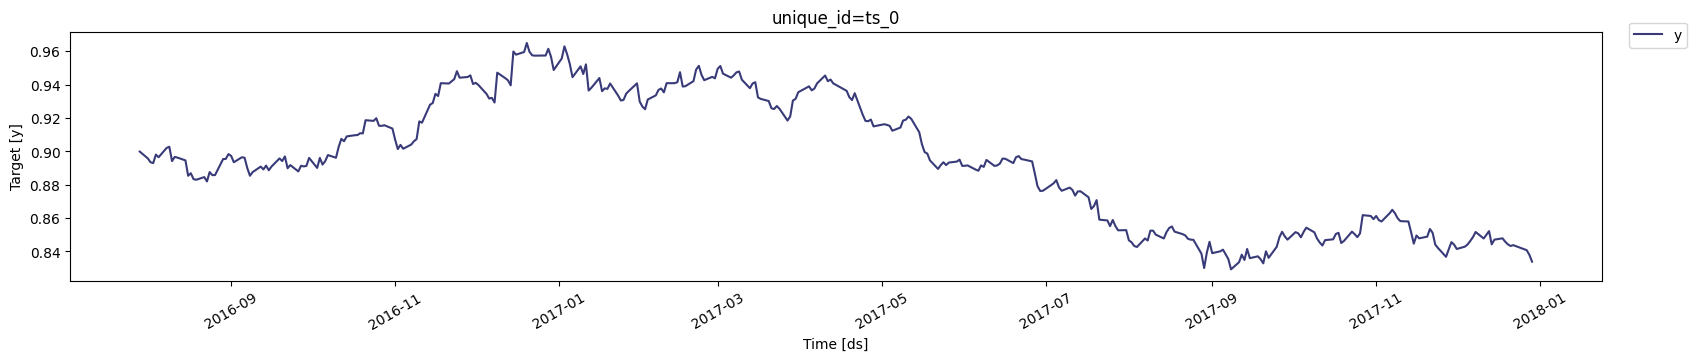

In [27]:
nixtla_client.plot(df, max_insample_length=365)

## Anomaly Detection

In [38]:
# Ensure 'ds' is a datetime column
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# Handling duplicates by averaging the values
df = df.groupby(df.index).mean()

# Resample the DataFrame to ensure it has a daily frequency
df = df.resample('D').mean()  # Use mean() during resampling to keep consistency

# Check if there are any missing values after resampling
print("Missing Values After Resampling:")
print(df.isna().sum())

# Calculate the mean for columns to use for filling missing values
mean_values = df.mean()

# Fill missing values with the calculated mean
df = df.fillna(mean_values)

# Reset index to make 'ds' a column again, if needed by the nixtla client
df.reset_index(inplace=True)

# Try running the anomaly detection again
anomalies_df = nixtla_client.detect_anomalies(df, freq='D')
print(anomalies_df.head())


Missing Values After Resampling:
y    1174
dtype: int64
          ds         y   TimeGPT  TimeGPT-hi-99  TimeGPT-lo-99  anomaly
0 2007-02-03  0.780189  0.776035       0.811152       0.740919    False
1 2007-02-04  0.780189  0.777251       0.812368       0.742135    False
2 2007-02-05  0.773800  0.770486       0.805602       0.735369    False
3 2007-02-06  0.772000  0.769287       0.804403       0.734170    False
4 2007-02-07  0.770100  0.769364       0.804480       0.734247    False


In [39]:
anomalies_df = nixtla_client.detect_anomalies(df, freq='D')
anomalies_df.head()

,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
0,2007-02-03,0.780189,0.776035,0.811152,0.740919,False
1,2007-02-04,0.780189,0.777251,0.812368,0.742135,False
2,2007-02-05,0.773800,0.770486,0.805602,0.735369,False
3,2007-02-06,0.772000,0.769287,0.804403,0.734170,False
4,2007-02-07,0.770100,0.769364,0.804480,0.734247,False


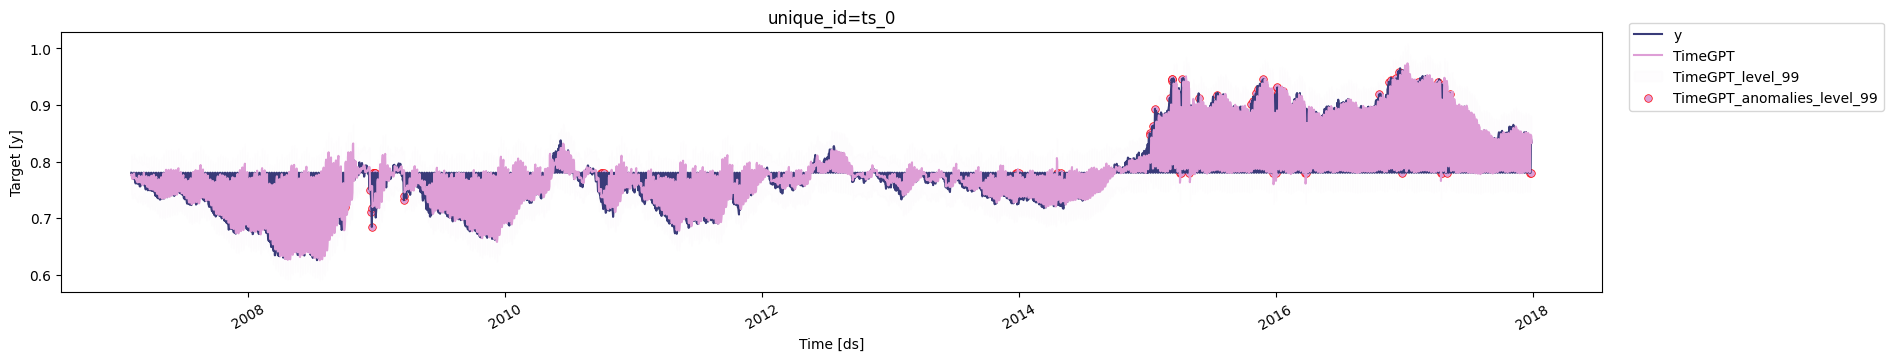

In [40]:
nixtla_client.plot(df, anomalies_df)

## Anomaly Detection with Exogenous Features

In [41]:
anomalies_df_x = nixtla_client.detect_anomalies(
    df,
    freq='D',
    date_features=['month', 'year'],
    date_features_to_one_hot=True,
)

<Axes: ylabel='features'>

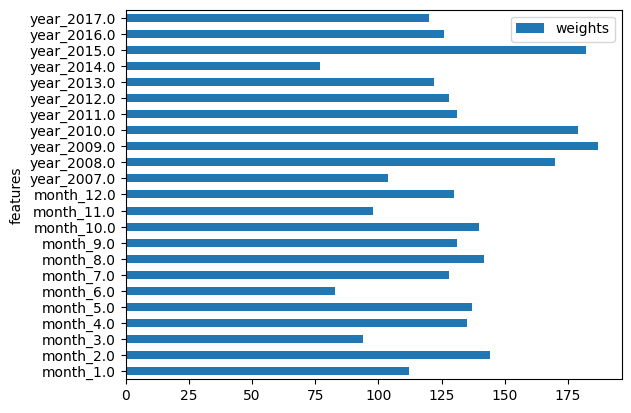

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

## Modifying the Confidence Intervals

In [42]:
anomalies_df = nixtla_client.detect_anomalies(
    df,
    freq='D',
    level=70
)

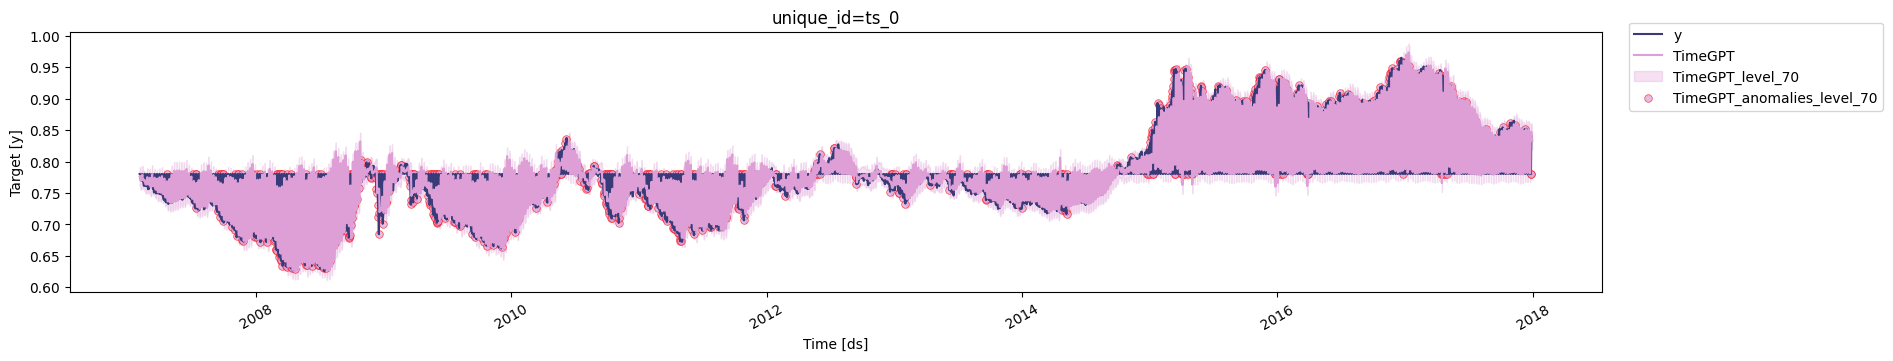

In [43]:
nixtla_client.plot(df, anomalies_df)